# Preprocessing & Modeling 

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

import librosa as lr
import librosa.display

import wave
from scipy.io import wavfile
import IPython.display as idp 

import warnings
warnings.filterwarnings("ignore")

In [487]:
# load dataframe

audio_df = pd.read_pickle('/Users/spence/Documents/GitHub/Urban Sounds Classifier/UrbanSound8K/feature extraction /audio_df.pkl')
audio_df_xtra = pd.read_pickle('/Users/spence/Documents/GitHub/Urban Sounds Classifier/UrbanSound8K/feature extraction /audio_df_xtra.pkl')

In [448]:
# examine columns 

audio_df.columns 

Index(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class', 'num_channels', 'sample_rate', 'bit_depth',
       'sound_len', 'mfccs'],
      dtype='object')

In [488]:
# examine columns 

audio_df_xtra.columns 

Index(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class', 'num_channels', 'sample_rate', 'bit_depth',
       'sound_len', 'mfccs', 'chroma', 'features', 'zero_cr'],
      dtype='object')

## Preprocessing

In [202]:
# import packages

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical 

In [424]:
# create seperate objects for independent and dependent variables 
X = np.array(audio_df['mfccs'].tolist())
y = np.array(audio_df['class'].tolist())

# label encode target variables 
le = LabelEncoder()
y_ = to_categorical(le.fit_transform(y))

# train/test split data
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.2, random_state=22)

## Modeling 

In [235]:
# import packages 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, Conv1D, MaxPooling2D, GlobalAveragePooling2D
from sklearn import metrics 

We are going to implement a Convolutional Neural Network to classify our audio. CNN's are typically used in image recognition. Since we have compiled an image based on the frequency composition of our audio, this approach is appropriate. 

First we need to handle the shape of our data. For CNN's it's important that the input shapes are consistent, so the model knows how to scan the image by way of its kernal. We will reshape the audio-image to fit into a 2-Dimensional CNN. 

In [425]:
# reshape the data to fit into a 2-Dimensional CNN; 40, rows, 174 columns, 1 channel(mono)
X_train = X_train.reshape(X_train.shape[0], 40, 174, 1)
X_test = X_test.reshape(X_test.shape[0], 40, 174, 1)

# create variable for the count of classes for our model's output layer; where predictions get mapped to the classes
class_count = y_.shape[1]

# variable for the shape of our independent variable data 
shape = (40, 174, 1)

_____________

## Model 1

In [400]:
# model architecture 

# instantiate model 
CNNmodel = Sequential()

# construct layers 
CNNmodel.add(Conv2D(16, 2, activation='relu', input_shape=shape ))
CNNmodel.add(MaxPooling2D((2,2)))
CNNmodel.add(Dropout(0.2))

CNNmodel.add(Conv2D(32, 2, activation='relu'))
CNNmodel.add(MaxPooling2D((2,2)))
CNNmodel.add(Dropout(0.2))

CNNmodel.add(Conv2D(64, 2, activation='relu'))
CNNmodel.add(Flatten())

CNNmodel.add(Dense(128, activation='relu'))
CNNmodel.add(Dropout(0.2))

CNNmodel.add(Dense(64, activation='relu'))

CNNmodel.add(Dense(num_labels, activation='softmax'))


In [401]:
# compile & fit model 

CNNmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

fitted_model = CNNmodel.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
219/219 [==============================] - 13s 55ms/step - loss: 2.9489 - accuracy: 0.3373 - val_loss: 1.5356 - val_accuracy: 0.4550
Epoch 2/20
219/219 [==============================] - 12s 53ms/step - loss: 1.2467 - accuracy: 0.5683 - val_loss: 1.2031 - val_accuracy: 0.6292
Epoch 3/20
219/219 [==============================] - 11s 52ms/step - loss: 0.9616 - accuracy: 0.6651 - val_loss: 0.9787 - val_accuracy: 0.6911
Epoch 4/20
219/219 [==============================] - 11s 52ms/step - loss: 0.8399 - accuracy: 0.7100 - val_loss: 0.8626 - val_accuracy: 0.7232
Epoch 5/20
219/219 [==============================] - 12s 53ms/step - loss: 0.7021 - accuracy: 0.7563 - val_loss: 0.7519 - val_accuracy: 0.7616
Epoch 6/20
219/219 [==============================] - 11s 51ms/step - loss: 0.6204 - accuracy: 0.7869 - val_loss: 0.8024 - val_accuracy: 0.7427
Epoch 7/20
219/219 [==============================] - 11s 52ms/step - loss: 0.5007 - accuracy: 0.8302 - val_loss: 0.6643 - val_accuracy:

In [402]:
# evaluate model on test set 

score = CNNmodel.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = CNNmodel.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9945551156997681
Testing Accuracy:  0.8487105965614319


Because of the gap between the training accuracy and the testing accuracy (~15%), we can deduce that our model is a bit overfitted. It has learned the training data very well, but is not generalizable to new, unseen data. 

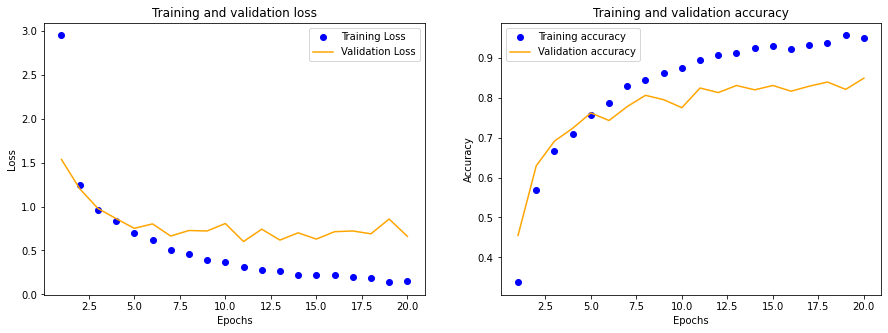

In [403]:
history_dict=fitted_model.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

We can see in the charts above that the model's validation accuracy doesn't improve much after 11 epochs. It's around that interation count that it starts to overfit. 

--------

## Model 2

Here we will try a redesign of our model architecture. We will avoid flattening the input and adding a 'Dense' layer this time around. We will only add a Dense layer at the end when it's necessary for mapping to the classes. 

In [426]:
# model architecture 

# instantiate model
model = Sequential()

# construct layers 
model.add(Conv2D(filters=16, kernel_size=2, activation='relu', input_shape=shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [342]:
# compile and fit model 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

model_ = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
219/219 [==============================] - 12s 52ms/step - loss: 2.0865 - accuracy: 0.3429 - val_loss: 1.4727 - val_accuracy: 0.5421
Epoch 2/100
219/219 [==============================] - 11s 51ms/step - loss: 1.2771 - accuracy: 0.5499 - val_loss: 1.2227 - val_accuracy: 0.6069
Epoch 3/100
219/219 [==============================] - 11s 52ms/step - loss: 1.1080 - accuracy: 0.6090 - val_loss: 1.1529 - val_accuracy: 0.6132
Epoch 4/100
219/219 [==============================] - 11s 51ms/step - loss: 0.9718 - accuracy: 0.6597 - val_loss: 1.0126 - val_accuracy: 0.6596
Epoch 5/100
219/219 [==============================] - 11s 50ms/step - loss: 0.8690 - accuracy: 0.6939 - val_loss: 0.9062 - val_accuracy: 0.7060
Epoch 6/100
219/219 [==============================] - 11s 50ms/step - loss: 0.7762 - accuracy: 0.7341 - val_loss: 0.8908 - val_accuracy: 0.7198
Epoch 7/100
219/219 [==============================] - 11s 50ms/step - loss: 0.7111 - accuracy: 0.7606 - val_loss: 0.7880 - val_ac

In [423]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9955580830574036
Testing Accuracy:  0.9358166456222534


These are great training and test scores! Our training and testing scores are relatively close (~7% difference) which shows the model hasn't been overfitted. 93.5% accuracy on unseen data is generally very good. 

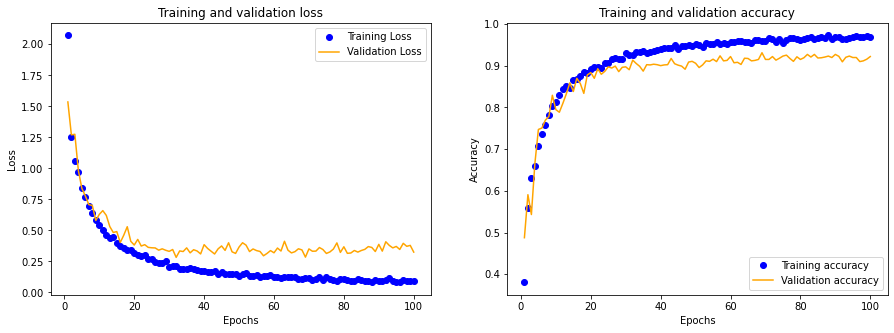

In [428]:
history_dict=model_.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,101)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

As we can see, the accuracy increases and flattens out around 90% accuracy at about 30 epochs and slowly moves up from there. 

_____________

## Model 3

Model redesign with enhanced feature space. Previously, we only used MFCC's as the feature to analyze for classification. In this round, we will include Chromagrams and Zero Cross Rate in our feature space to see if we can boost the accuracy score up. 

In [489]:
# create seperate objects for independent and dependent variables 
X = np.array(audio_df_xtra['features'].tolist())
y = np.array(audio_df_xtra['class'].tolist())

# label encode target variables 
le = LabelEncoder()
y_ = to_categorical(le.fit_transform(y))

# train/test split data
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.2, random_state=22)

In [490]:
# reshape the data to fit into a 2-Dimensional CNN; 42 (beause two new features were added), 174, 1
X_train = X_train.reshape(X_train.shape[0], 42, 174, 1)
X_test = X_test.reshape(X_test.shape[0], 42, 174, 1)

# create variable for the count of classes for our model's output layer; where predictions get mapped to the classes
class_count = y_.shape[1]

# variable for the shape of our independent variable data 
shape = (42, 174, 1)

In [491]:
# model architecture - using the same architecture as the previous model 

# instantiate model
model_3 = Sequential()

# construct layers 
model_3.add(Conv2D(filters=16, kernel_size=2, activation='relu', input_shape=shape))
model_3.add(MaxPooling2D(pool_size=2))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_3.add(MaxPooling2D(pool_size=2))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_3.add(MaxPooling2D(pool_size=2))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_3.add(MaxPooling2D(pool_size=2))
model_3.add(Dropout(0.2))

model_3.add(GlobalAveragePooling2D())

model_3.add(Dense(num_labels, activation='softmax')) 

In [492]:
# compile model 

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [493]:
#num_epochs = 12
#num_batch_size = 128

num_epochs = 72
num_batch_size = 256

model_3_ = model_3.fit(X_train, y_train, epochs=75, validation_data=(X_test, y_test), verbose=1)


Epoch 1/75
219/219 [==============================] - 34s 89ms/step - loss: 2.2089 - accuracy: 0.3751 - val_loss: 1.5364 - val_accuracy: 0.5135
Epoch 2/75
219/219 [==============================] - 13s 61ms/step - loss: 1.3085 - accuracy: 0.5413 - val_loss: 1.2538 - val_accuracy: 0.6172
Epoch 3/75
219/219 [==============================] - 13s 61ms/step - loss: 1.1341 - accuracy: 0.6044 - val_loss: 1.1538 - val_accuracy: 0.6304
Epoch 4/75
219/219 [==============================] - 14s 62ms/step - loss: 0.9830 - accuracy: 0.6565 - val_loss: 0.9774 - val_accuracy: 0.6986
Epoch 5/75
219/219 [==============================] - 13s 60ms/step - loss: 0.8813 - accuracy: 0.6929 - val_loss: 0.9149 - val_accuracy: 0.7135
Epoch 6/75
219/219 [==============================] - 13s 57ms/step - loss: 0.7869 - accuracy: 0.7276 - val_loss: 0.8244 - val_accuracy: 0.7318
Epoch 7/75
219/219 [==============================] - 17s 76ms/step - loss: 0.6980 - accuracy: 0.7596 - val_loss: 0.8096 - val_accuracy:

In [494]:
# Evaluating the model on the training and testing set
score = model_3.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model_3.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9921191930770874
Testing Accuracy:  0.9209169149398804


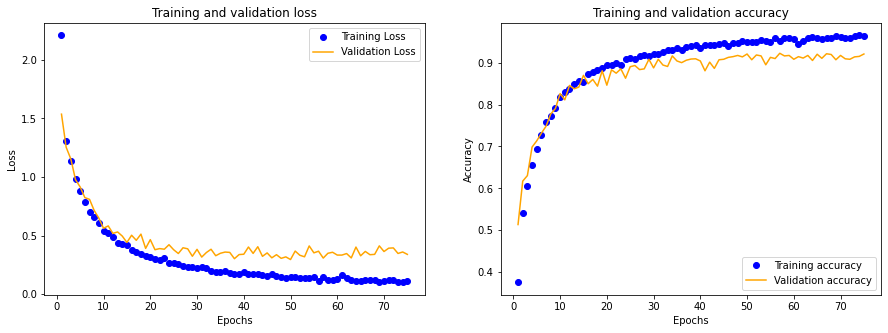

In [495]:
history_dict=model_3_.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,76)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

We get basically the same evaluation scores as the previous model, meaning our added features didn't contibute anything. MFCC extraction is a *very* popular method for audio analysis and clearly for a reason. It is robust in the amount of information it extracts, and performs very well on it's own in classifying audio.